In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
from fbprophet import Prophet

In [6]:
houses = pd.read_csv("./../src/data/raw/assessor.csv")
houses.head()

,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,...,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Analysis Neighborhood,the_geom,Row ID
0,2007.0,0000 0000 0000,1378007,1378,007,10,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,0,0,0,1.0,1D,Lake --The Presidio,1,Outer Richmond,POINT (-122.478111692066 37.785130177493),20071378007
1,2008.0,0000 0000 0000,1345001,1345,001,10,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,0,0,0,1.0,1D,Lake --The Presidio,2,Inner Richmond,POINT (-122.46850833548 37.787296873264),20081345001
2,2008.0,0000 0000 0000,5607046,5607,046,33,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,0,0,0,9.0,9A,Bernal Heights,9,Portola,POINT (-122.408022500468 37.737569794488),20085607046
3,2009.0,0000 0297 BALTIMORE WY0000,6499040,6499,040,38,SRES,Single Family Residential,D,Dwelling,...,45734,22044,0,10.0,10B,Croker Amazon,11,Excelsior,POINT (-122.437016077245 37.708207457788),20096499040
4,2010.0,0000 1715 SITUS TO BE ASSIGNEDST0000,0663054,0663,054,5,COMM,Commercial Misc,E,Schools,...,0,0,0,6.0,6C,Lower Pacific Heights,5,Pacific Heights,POINT (-122.427448868223 37.78845382468),20100663054


In [22]:
from scipy import stats

my_data = houses.loc[houses['Assessor Neighborhood'] == "Bernal Heights" ]
final = my_data[['Closed Roll Year', 'Assessed Improvement Value', 'Assessed Land Value','Property Location']]
final.rename(columns={ "Closed Roll Year": "my_index"}, inplace = True)

final['y'] = final['Assessed Improvement Value'] + final['Assessed Land Value']
# final = np.around(final[['my_index']],decimals= 0)
final['z'] = np.abs(stats.zscore(final['Assessed Improvement Value']))
final['z2'] = np.abs(stats.zscore(final['Assessed Land Value']))
# final[final['Property Location'].replace(final['Property Location'].apply(pd.Series.value_counts)).gt(2).all(1)]
v = final[['Property Location']]

final = final[v.replace(v.stack().value_counts()).gt(5).all(1)]
final = final[final.z < 3]
final = final[final.z2 < 3]




final['y'] = final['Assessed Improvement Value'] + final['Assessed Land Value']

final.sort_values(by=['Property Location'])

,my_index,Assessed Improvement Value,Assessed Land Value,Property Location,y,z,z2
2,2008.0,0,0,0000 0000 0000,0,0.584585,0.951061
747076,2010.0,0,0,0000 0000 0000,0,0.584585,0.951061
746934,2010.0,0,0,0000 0000 0000,0,0.584585,0.951061
141986,2007.0,0,0,0000 0000 0000,0,0.584585,0.951061
746651,2010.0,0,0,0000 0000 0000,0,0.584585,0.951061
958394,2011.0,0,0,0000 0000 0000,0,0.584585,0.951061
1565799,2014.0,0,0,0000 0000 0000,0,0.584585,0.951061
958455,2011.0,0,23052,0000 0000 0000,23052,0.584585,0.863470
746452,2010.0,0,0,0000 0000 0000,0,0.584585,0.951061
746255,2010.0,0,0,0000 0000 0000,0,0.584585,0.951061


In [17]:
final = final.groupby('my_index').mean()
final['y'] = final['Assessed Improvement Value'] + final['Assessed Land Value']
final = np.around(final[['y']],decimals= 3)

final['ds'] = final.index
final["ds"] = final.ds.astype(float)
final.ds = final.ds.astype(int)
# final.y = final.y.astype(int)

# final = final.astype(np.float64)
# final['ds'] = le.fit_transform(final['ds'].astype(int))
# final['ds']= pd.to_datetime(final['ds'], format='%Y')

final['ds'] = final['ds'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y'))

final

,y,ds
my_index,,
2007.0,346335.553,2007-01-01
2008.0,364809.796,2008-01-01
2009.0,378276.532,2009-01-01
2010.0,387997.751,2010-01-01
2011.0,393006.695,2011-01-01
2012.0,411620.713,2012-01-01
2013.0,426563.178,2013-01-01
2014.0,433996.956,2014-01-01
2016.0,459446.064,2016-01-01


In [24]:
m = Prophet( interval_width=0.95, yearly_seasonality=False, changepoint_prior_scale=0.5)
m.fit(final)
future = m.make_future_dataframe(periods = 3, freq= 'Y')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.


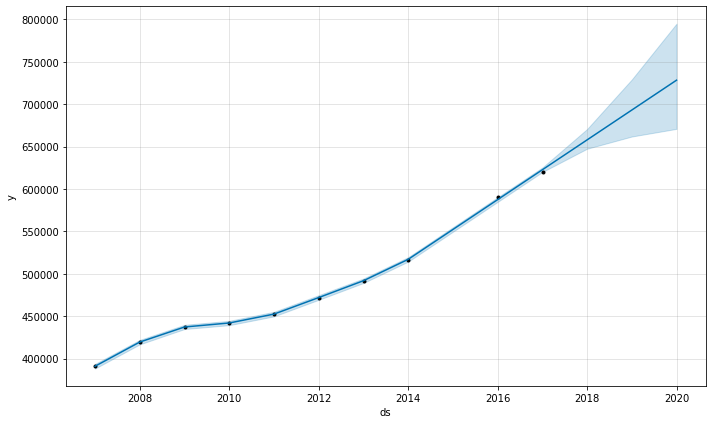

In [25]:
# m.plot_components(forecast)
fig1 = m.plot(forecast)

In [42]:
houses = pd.read_csv("./../src/data/raw/housing_inventories.csv")
houses.head()

,ACTDT,YEAR,YR_QTR,ACTION,APP_NO,FM,NUMBER,STREET,ST_TYPE,BLOCK,...,PROP_USE,AFF_HSG,AFF_TARGET,UNITS,NETUNITS,planning_district_number,planning_district,supervisor_district,analysis_neighborhood,the_geom
0,10/4/2017,2017,2017_Q4,COMPLETE,2.01405E+11,2,4126,17TH,ST,2623,...,1 FAMILY DWELLING,NaN,NaN,1,1,6.0,Buena Vista,8.0,Castro/Upper Market,POINT (-122.437967535916 37.762616837591)
1,1/10/2017,2017,2017_Q1,COMPLETE,2.00712E+11,2,353,SAN JOSE,AV,6531,...,APARTMENTS,NaN,NaN,4,4,8.0,Mission,8.0,Mission,POINT (-122.421090538371 37.749539665099)
2,2/15/2018,2018,2018_Q1,COMPLETE,2.01512E+11,3,1545,PINE,ST,667,...,APARTMENTS,NaN,NaN,100,-3,3.0,Northeast,3.0,Nob Hill,POINT (-122.421224446811 37.789277040877)
3,1/6/2017,2017,2017_Q1,COMPLETE,2.01209E+11,2,2877,SAN BRUNO,AV,5457,...,2 FAMILY DWELLING,NaN,NaN,2,2,12.0,South Central,9.0,Portola,POINT (-122.40246178601 37.725546734725)
4,3/10/2017,2017,2017_Q1,COMPLETE,2.01402E+11,6,1900,18TH,ST,4008,...,NaN,NaN,NaN,-3,-3,9.0,South of Market,10.0,Potrero Hill,POINT (-122.401712073283 37.762569743259)


In [70]:
from scipy import stats

my_data = houses.loc[houses['analysis_neighborhood'] == "Mission" ]
final = my_data[[ 'ACTDT', 'UNITS','analysis_neighborhood']]
final['my_index'] = final['ACTDT'].astype(str).apply(lambda x: pd.to_datetime(x))

final = final.sort_values(by=['my_index'])
final['UNITS'] = final.UNITS.astype(int)
final = final[final.UNITS >= 0]

final = final.groupby('my_index').mean()
final = final[final.UNITS >= 0]

final.rename(columns={ "UNITS": "y"}, inplace = True)
final['ds'] = final.index

# final.rename(columns={ "Closed Roll Year": "my_index"}, inplace = True)

# final['y'] = final['Assessed Improvement Value'] + final['Assessed Land Value']
# # final = np.around(final[['my_index']],decimals= 0)
# final['z'] = np.abs(stats.zscore(final['y']))

final

,y,ds
my_index,,
2005-01-24,0.000000,2005-01-24
2005-02-03,0.000000,2005-02-03
2005-03-16,0.000000,2005-03-16
2005-04-14,0.000000,2005-04-14
2005-04-27,0.000000,2005-04-27
2005-05-02,0.000000,2005-05-02
2005-06-13,0.000000,2005-06-13
2005-07-19,0.000000,2005-07-19
2005-08-29,0.000000,2005-08-29


In [71]:
m = Prophet( yearly_seasonality =True )
m.fit(final)
future = m.make_future_dataframe(periods = 3, freq= 'M')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


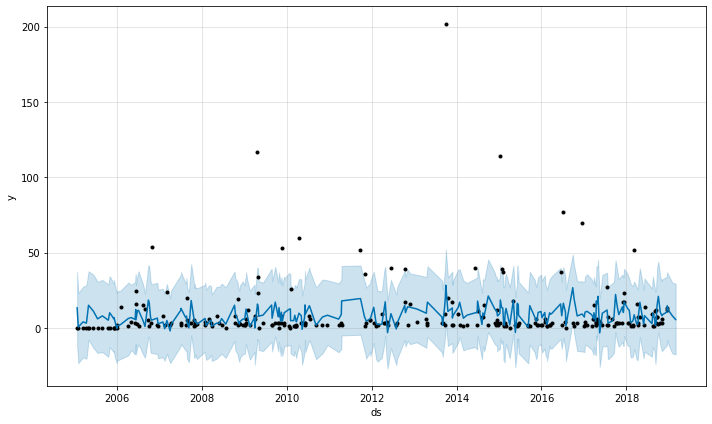

In [72]:
fig1 = m.plot(forecast)